In [1]:
import random, os, functools, statistics

import numpy as np
import matplotlib.pyplot as plt
import dill, joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from glio.train2 import *
from glio.train2.cbs_summary import Summary
from glio.visualize import vis_imshow, vis_imshow_grid, Visualizer
from glio.jupyter_tools import show_slices, show_slices_arr, clean_mem
from glio.torch_tools import area_around, one_hot_mask, summary, lr_finder, to_binary, count_parameters
from glio.python_tools import type_str, CacheRepeatIterator, get_all_files
from glio import nn as gnn
from glio.nn import conv, convt, linear, seq, block
from glio.data import DSToTarget
from glio.helpers import cnn_output_size, tcnn_output_size
from glio.loaders import nifti
from glio.transforms import fToChannels, fToChannelsFirst,fToChannelsLast, z_normalize, norm_to01

from monai.losses.dice import DiceLoss, DiceFocalLoss
from monai.metrics import MeanIoU, SurfaceDiceMetric, DiceHelper # type:ignore
from schedulefree import AdamWScheduleFree

inp.shape = torch.Size([4, 96, 96]), target.shape = torch.Size([4, 96, 96])
ds.get_preloaded_percent() = 1.0
len(ds) = 120632
len(dstrain) = 108568, len(dstest) = 12064


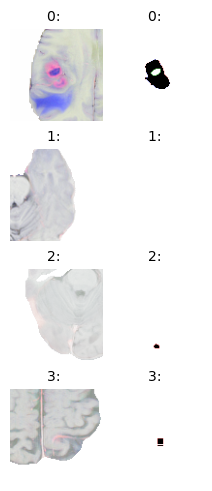

In [2]:
TITLE = "BRATS2024 2D segm - overnight"
PRELOAD = 1.

def loader(path:str):
    return torch.tensor(np.stack(list(np.load(path).values())), dtype=torch.float16)[:,-112:112,-112:112]

def tfm_input(data):
    return data[:4].to(torch.float32)

def tfm_target(data):
    return one_hot_mask(data[4], 4)

img = loader(r"E:\dataset\BRaTS2024 2D\images\BraTS-GoAT-00000\BraTS-GoAT-00000_21.npz")
inp = tfm_input(img)
target = tfm_target(img)

print(f"{inp.shape = }, {target.shape = }")

# ds = DSToTarget()
# ds.add_folder(r"E:\dataset\BRaTS2024 2D\images", loader, None, tfm_input, tfm_target)
# ds.preload(PRELOAD, True)

ds:DSToTarget = joblib.load(r"F:\Stuff\Programming\experiments\ai\BRaTS2024 preloaded ds.joblib")
print(f"{ds.get_preloaded_percent() = }")
print(f"{len(ds) = }")
dstrain, dstest = ds.split(0.9)
print(f"{len(dstrain) = }, {len(dstest) = }")
dstrain.preview()

def plot_preds(learner:Learner, batch, softmax = True, unsqueeze = True):
    batch = list(batch)
    if unsqueeze:
        batch[0] = batch[0].unsqueeze(0)
        batch[1] = batch[1].unsqueeze(0)
    preds = learner.inference(batch[0])
    v = Visualizer()
    v.imshow_grid(batch[0][0], mode="bhw", label="вход")
    v.imshow_grid(batch[1][0], mode="bhw", label = "реальная карта")
    if softmax:
        output = torch.stack([preds[0],preds[0],preds[0]], dim=1)
        output[:,0] *=  F.softmax(preds[0],0)
        v.imshow_grid(output, mode="bchw", label="сырой выход")
        v.imshow_grid(to_binary(F.softmax(preds[0], 0)), mode="bhw", label="предсказанная карта")
    else:
        v.imshow_grid(preds[0], mode="bchw", label="сырой выход")
        v.imshow_grid(to_binary(preds[0], 0), mode="bhw", label="предсказанная карта")
    v.show(figsize=(24, 24), nrows=1)

def eval_on_brats_2d(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    images = [loader(i) for i in get_all_files(folder)]
    inputs = torch.stack([tfm_input(i) for i in images])
    targets = torch.stack([tfm_target(i) for i in images])
    preds = learner.inference(inputs)
    preds_softmax = F.softmax(preds, 0)
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)
    t1 = torch.cat([norm_to01(inputs), norm_to01(targets), norm_to01(preds)], 3)
    t2 = torch.cat([norm_to01(preds_softmax), norm_to01(preds_binary), norm_to01(preds_binary_softmax)], 3)
    t = torch.cat([t1, t2], 2)
    show_slices(t)
    
def find_file_containing(folder, contains:str, recursive = True):
    for f in get_all_files(folder, recursive=recursive):
        if contains in f:
            return f
    raise FileNotFoundError(f"No file containing {contains} in {folder}")


from monai.inferers import SlidingWindowInfererAdapt # type:ignore
def eval_on_rhuh_slices(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    t1c = z_normalize(nifti.read(find_file_containing(folder, "t1ce")))
    t1n = z_normalize(nifti.read(find_file_containing(folder, "t1.")))
    t2f = z_normalize(nifti.read(find_file_containing(folder, "flair")))
    t2w = z_normalize(nifti.read(find_file_containing(folder, "t2")))
    seg = one_hot_mask(nifti.read(find_file_containing(folder, "seg")), 4).swapaxes(0,1)

    inputs = torch.stack([t1c, t1n, t2f, t2w]).swapaxes(0,1)
    inferer = SlidingWindowInfererAdapt(roi_size = (96,96), sw_batch_size = 32)
    preds = inferer(inputs, learner.inference)
    

    preds_softmax = F.softmax(preds, 0) # type:ignore
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)# type:ignore
    t1 = torch.cat([norm_to01(inputs), norm_to01(seg), norm_to01(preds)], 3)
    t2 = torch.cat([norm_to01(preds_softmax), norm_to01(preds_binary), norm_to01(preds_binary_softmax)], 3)
    t = torch.cat([norm_to01(t1), norm_to01(t2)], 2)
    show_slices(norm_to01(t))
    
def eval_on_brats_slices(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    t1c = z_normalize(nifti.read(find_file_containing(folder, "t1c")))
    t1n = z_normalize(nifti.read(find_file_containing(folder, "t1n")))
    t2f = z_normalize(nifti.read(find_file_containing(folder, "t2f")))
    t2w = z_normalize(nifti.read(find_file_containing(folder, "t2w")))
    seg = one_hot_mask(nifti.read(find_file_containing(folder, "seg")), 4).swapaxes(0,1)

    inputs = torch.stack([t1c, t1n, t2f, t2w]).swapaxes(0,1)
    inferer = SlidingWindowInfererAdapt(roi_size = (96,96), sw_batch_size = 32)
    preds = inferer(inputs, learner.inference)
    

    preds_softmax = F.softmax(preds, 0) # type:ignore
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)# type:ignore
    t1 = torch.cat([norm_to01(inputs), norm_to01(seg), norm_to01(preds)], 3)
    t2 = torch.cat([norm_to01(preds_softmax), norm_to01(preds_binary), norm_to01(preds_binary_softmax)], 3)
    t = torch.cat([norm_to01(t1), norm_to01(t2)], 2)
    show_slices(norm_to01(t))
    
    
def eval_on_brats_slices_sep_arr(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    t1c = z_normalize(nifti.read(find_file_containing(folder, "t1c")).to(torch.float32))
    t1n = z_normalize(nifti.read(find_file_containing(folder, "t1n")).to(torch.float32))
    t2f = z_normalize(nifti.read(find_file_containing(folder, "t2f")).to(torch.float32))
    t2w = z_normalize(nifti.read(find_file_containing(folder, "t2w")).to(torch.float32))
    seg = one_hot_mask(nifti.read(find_file_containing(folder, "seg")), 4).swapaxes(0,1)

    inputs = torch.stack([t1c, t1n, t2f, t2w]).swapaxes(0,1)
    inferer = SlidingWindowInfererAdapt(roi_size = (96,96), sw_batch_size = 32, overlap=0.1)
    preds = inferer(inputs, learner.inference)
    

    preds_softmax = F.softmax(preds, 0) # type:ignore
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)# type:ignore
    show_slices_arr(torch.stack([inputs, seg, preds, preds_softmax, preds_binary, preds_binary_softmax]))

In [3]:
from monai.networks.nets import VNet # type:ignore

print(f"{count_parameters(VNet(2, 4, 4)) = }")
summary(VNet(2, 4,4), (8, 4, 96,96))

count_parameters(VNet(2, 4, 4)) = 9361548
path                                         module                                       input size               output size              params    buffers   
monai.networks.nets.vnet.VNet/in_tr/conv_block/convtorch.nn.modules.conv.Conv2d                 (8, 4, 96, 96)           (8, 16, 96, 96)          1600      0         
monai.networks.nets.vnet.VNet/in_tr/conv_block/adn/Ntorch.nn.modules.batchnorm.BatchNorm2d       (8, 16, 96, 96)          (8, 16, 96, 96)          32        33        
monai.networks.nets.vnet.VNet/in_tr/act_functiontorch.nn.modules.activation.ELU              (8, 16, 96, 96)          (8, 16, 96, 96)          0         0         
monai.networks.nets.vnet.VNet/down_tr32/down_convtorch.nn.modules.conv.Conv2d                 (8, 16, 96, 96)          (8, 32, 48, 48)          2048      0         
monai.networks.nets.vnet.VNet/down_tr32/bn1  torch.nn.modules.batchnorm.BatchNorm2d       (8, 32, 48, 48)          (8, 32, 48, 48)   

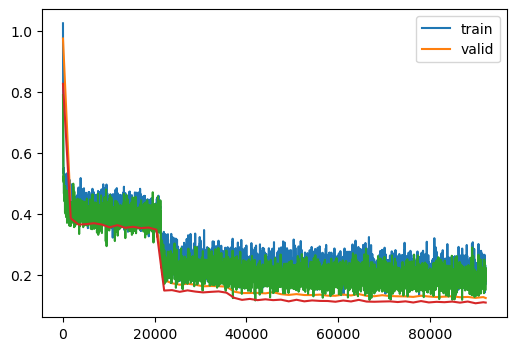

Keyboard interrupt, testing one last time... Press stop again to cancel.
test loss: min: 0.1246; max: 0.9749; last: 0.1246
test fn - monai.losses.dice.DiceLoss: min: 0.1073; max: 0.8263; last: 0.1097
time: min: 22.9986; max: 31048.6711; last: 31048.6711
lr: min: 0.0100; max: 0.0100; last: 0.0100
train loss: min: 0.1130; max: 1.0248; last: 0.2306
train fn - monai.losses.dice.DiceLoss: min: 0.0986; max: 0.7894; last: 0.1992


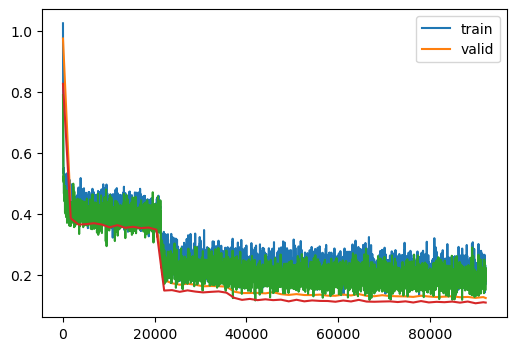

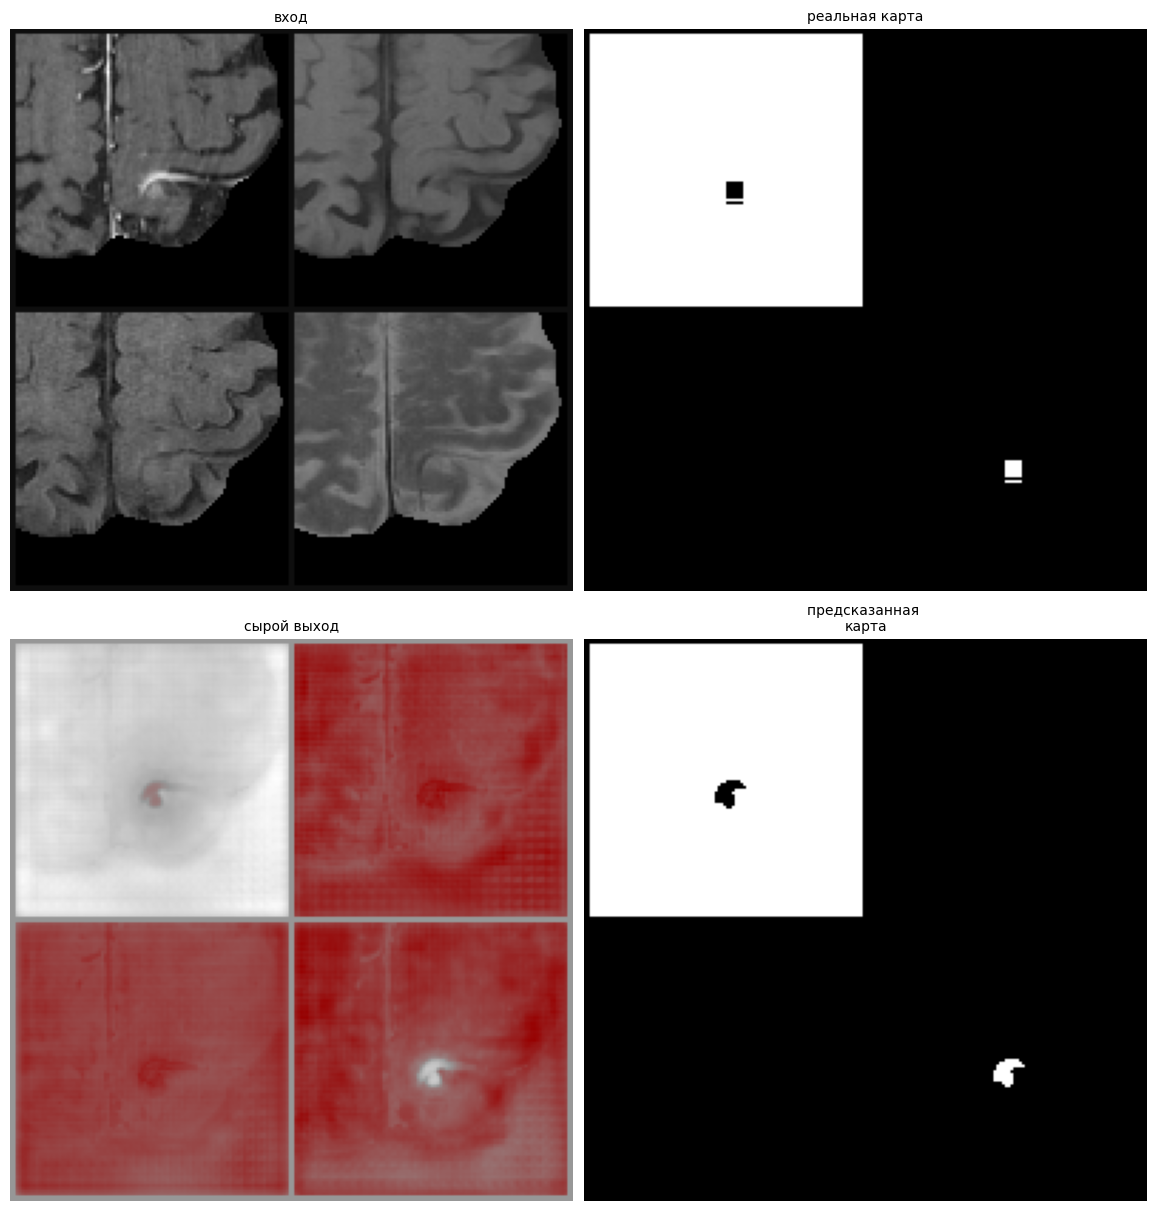

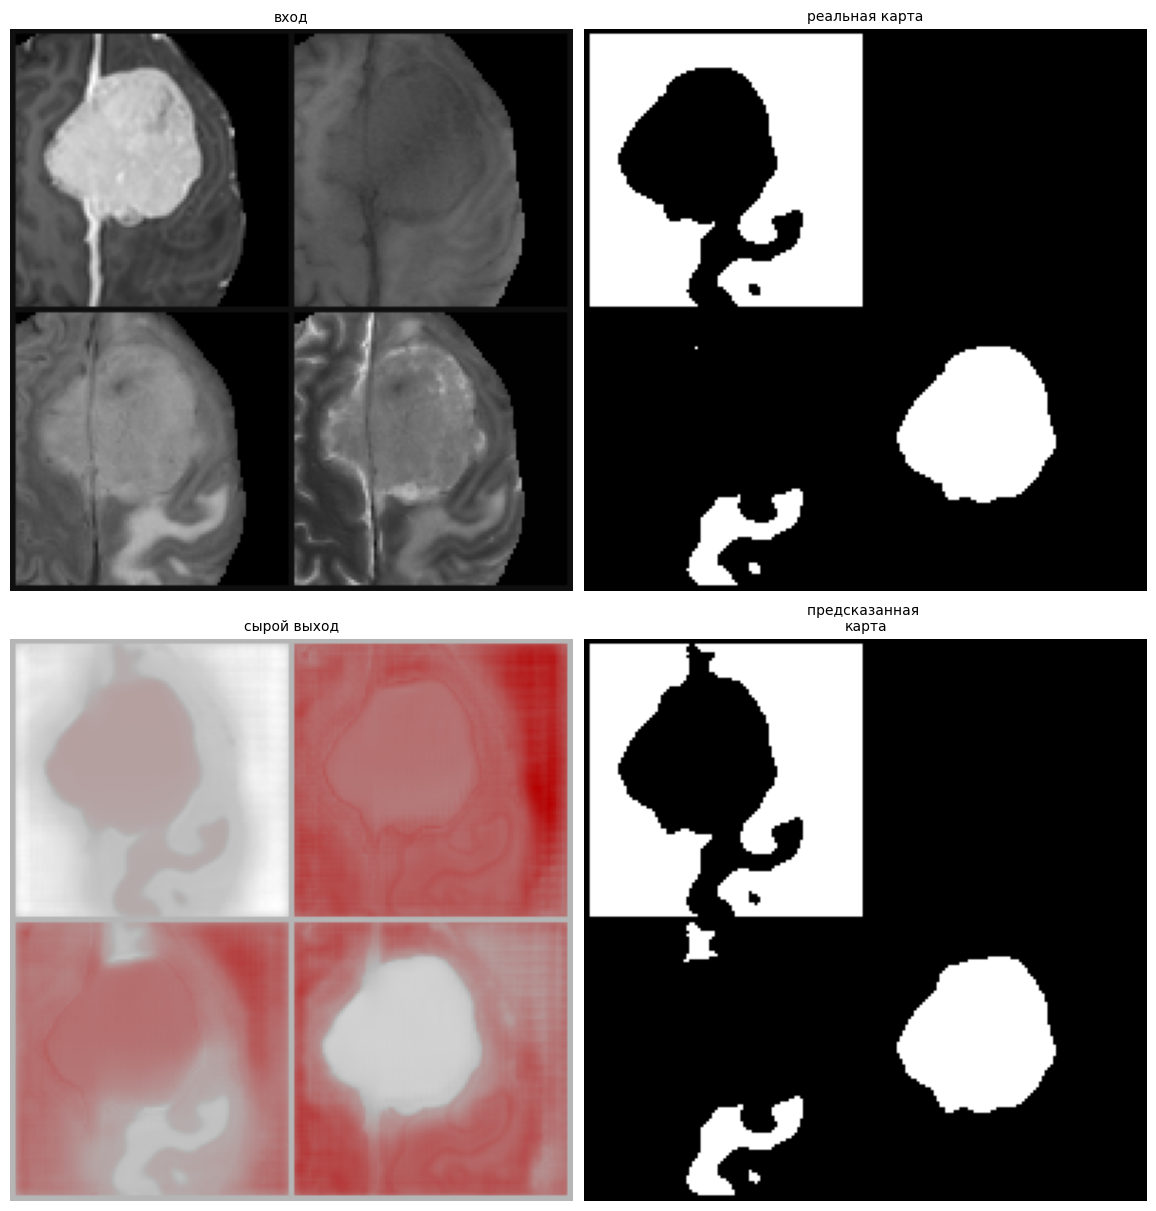

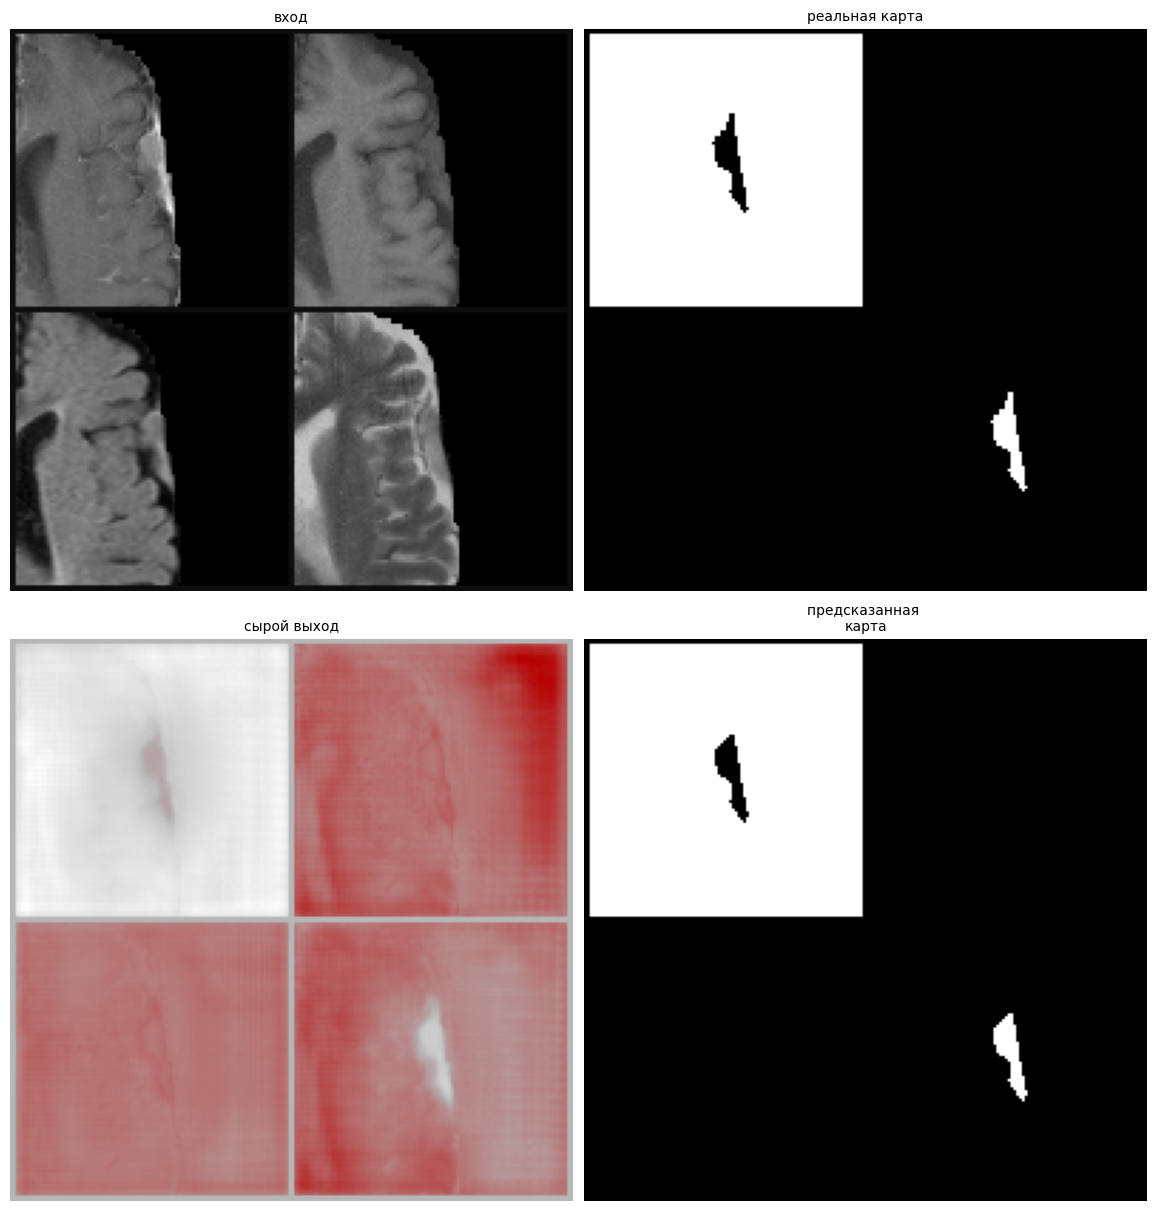

In [4]:
MODEL = VNet(2, 4,4)
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-2
BATCH_SIZE = 64
N_EPOCHS = 100

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = AdamWScheduleFree(MODEL.parameters(), lr=LR, eps=1e-6)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()
#model = gnn.LSUV(model, dl_train)

LEARNER_NAME = f"{NAME} lr={LR} bs={BATCH_SIZE} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16),
                         Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), Summary(), Accelerate("no"), 
                         Metric_PredsTargetsFn(DiceLoss(softmax=True), step=4),
                         FastProgressBar(plot=True, step_batch=16, metrics=
                                         ["train loss", "test loss", "train fn - monai.losses.dice.DiceLoss", "test fn - monai.losses.dice.DiceLoss"]),
                         ),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest)

plt.show()
plot_preds(learner, dstrain[3], softmax=True)
plot_preds(learner, dstrain[4], softmax=True)
plot_preds(learner, dstrain[6], softmax=True)


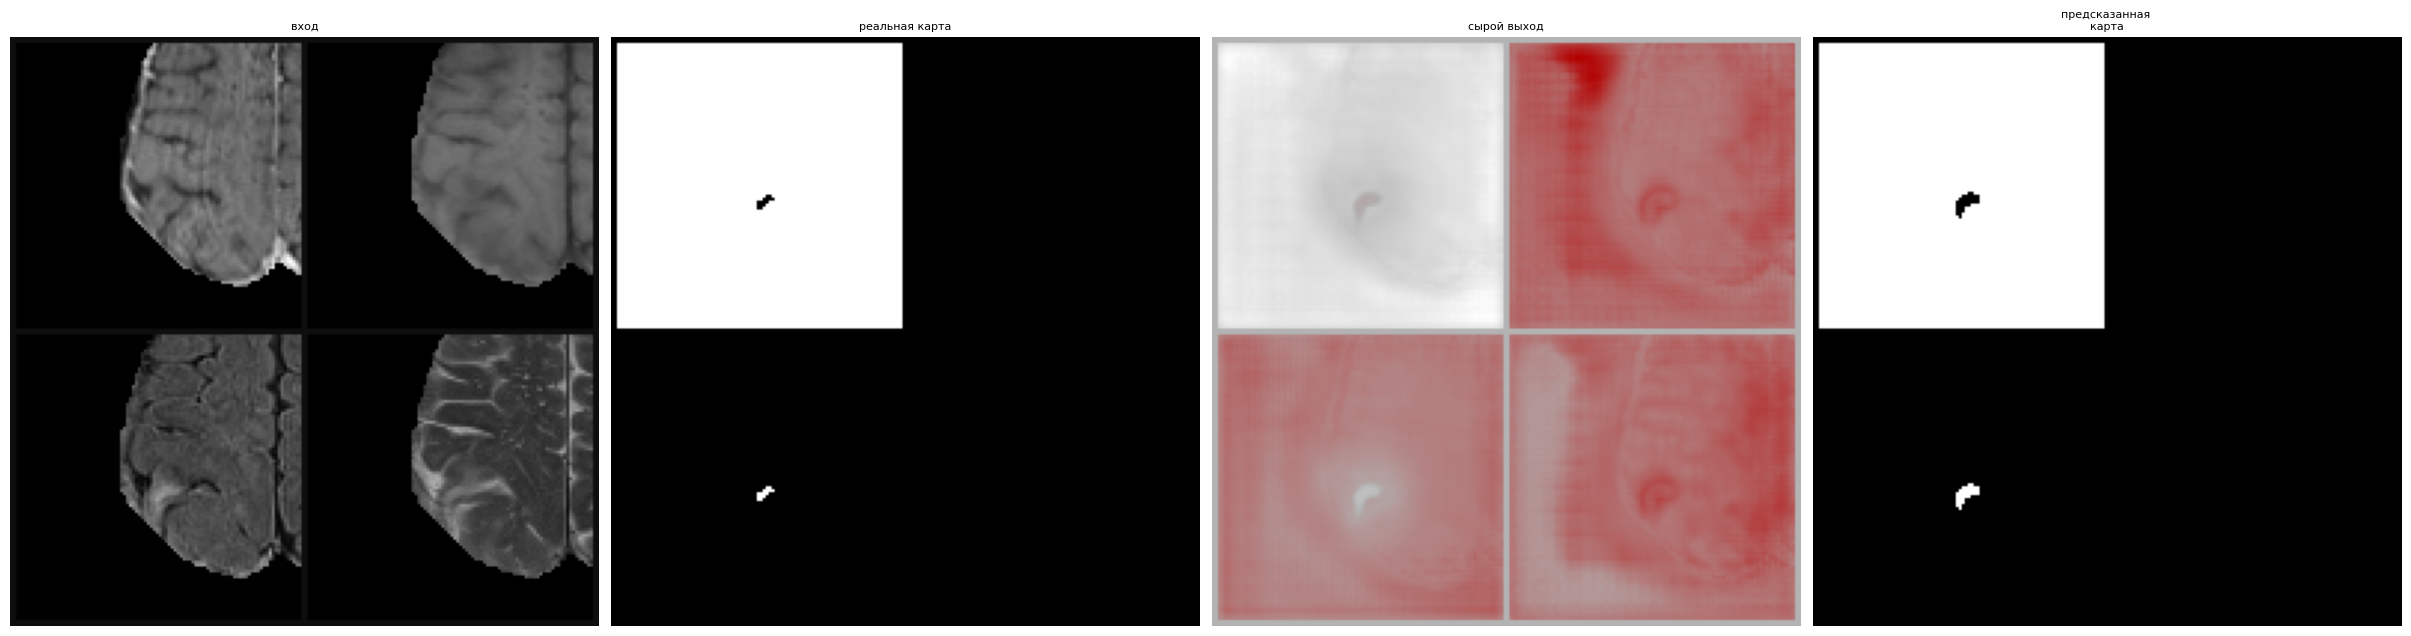

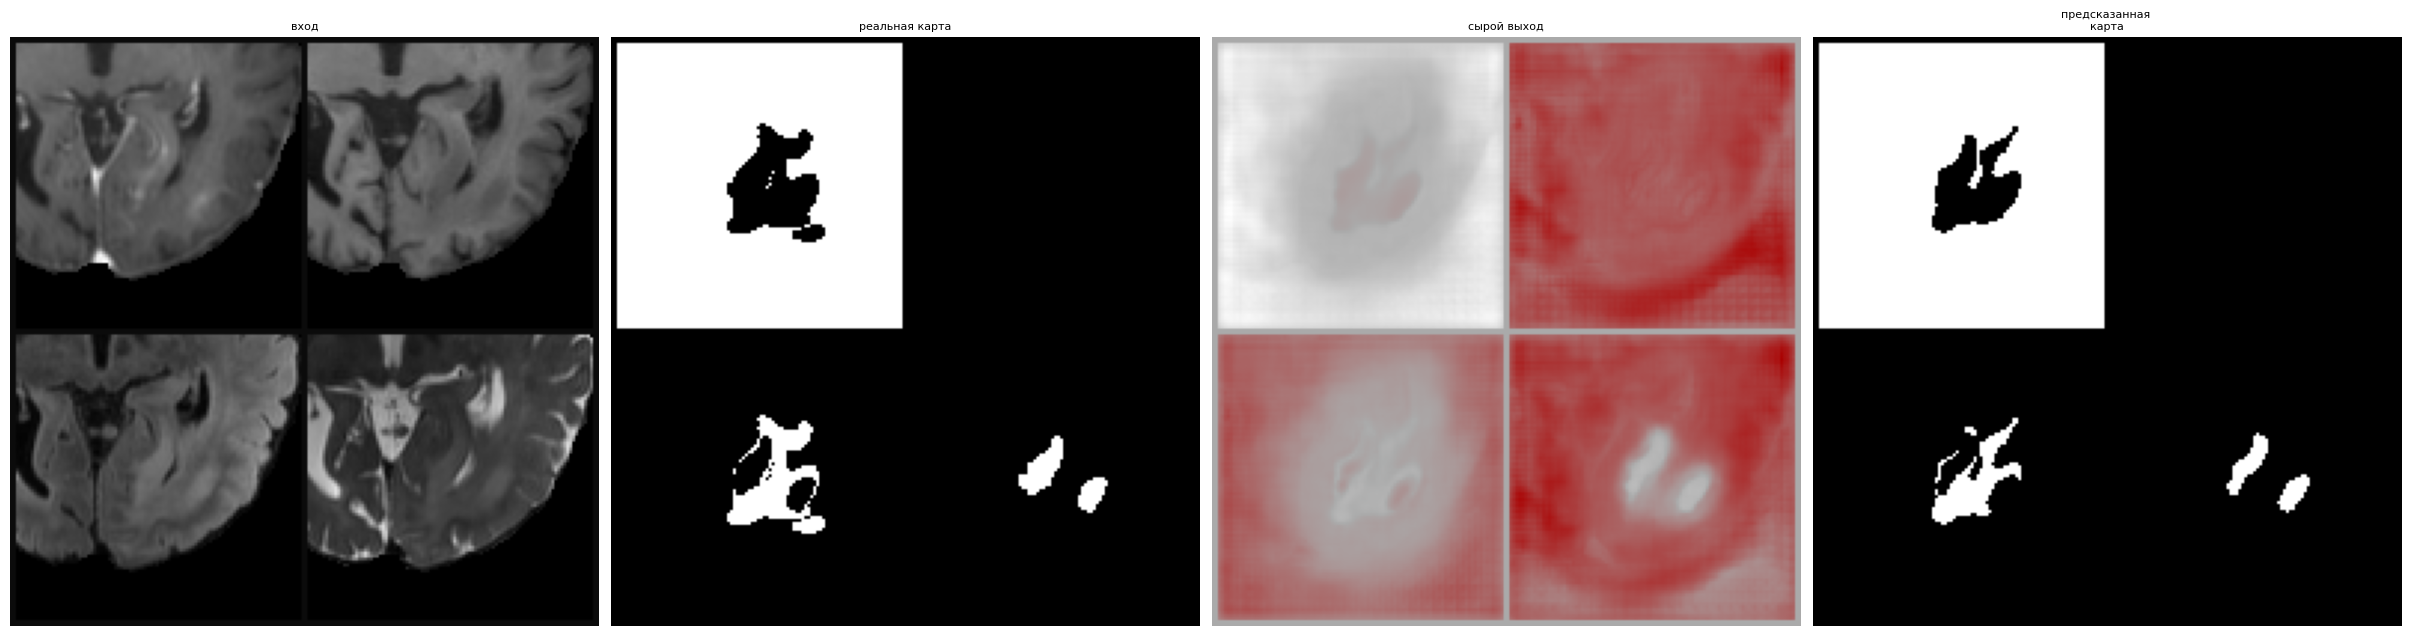

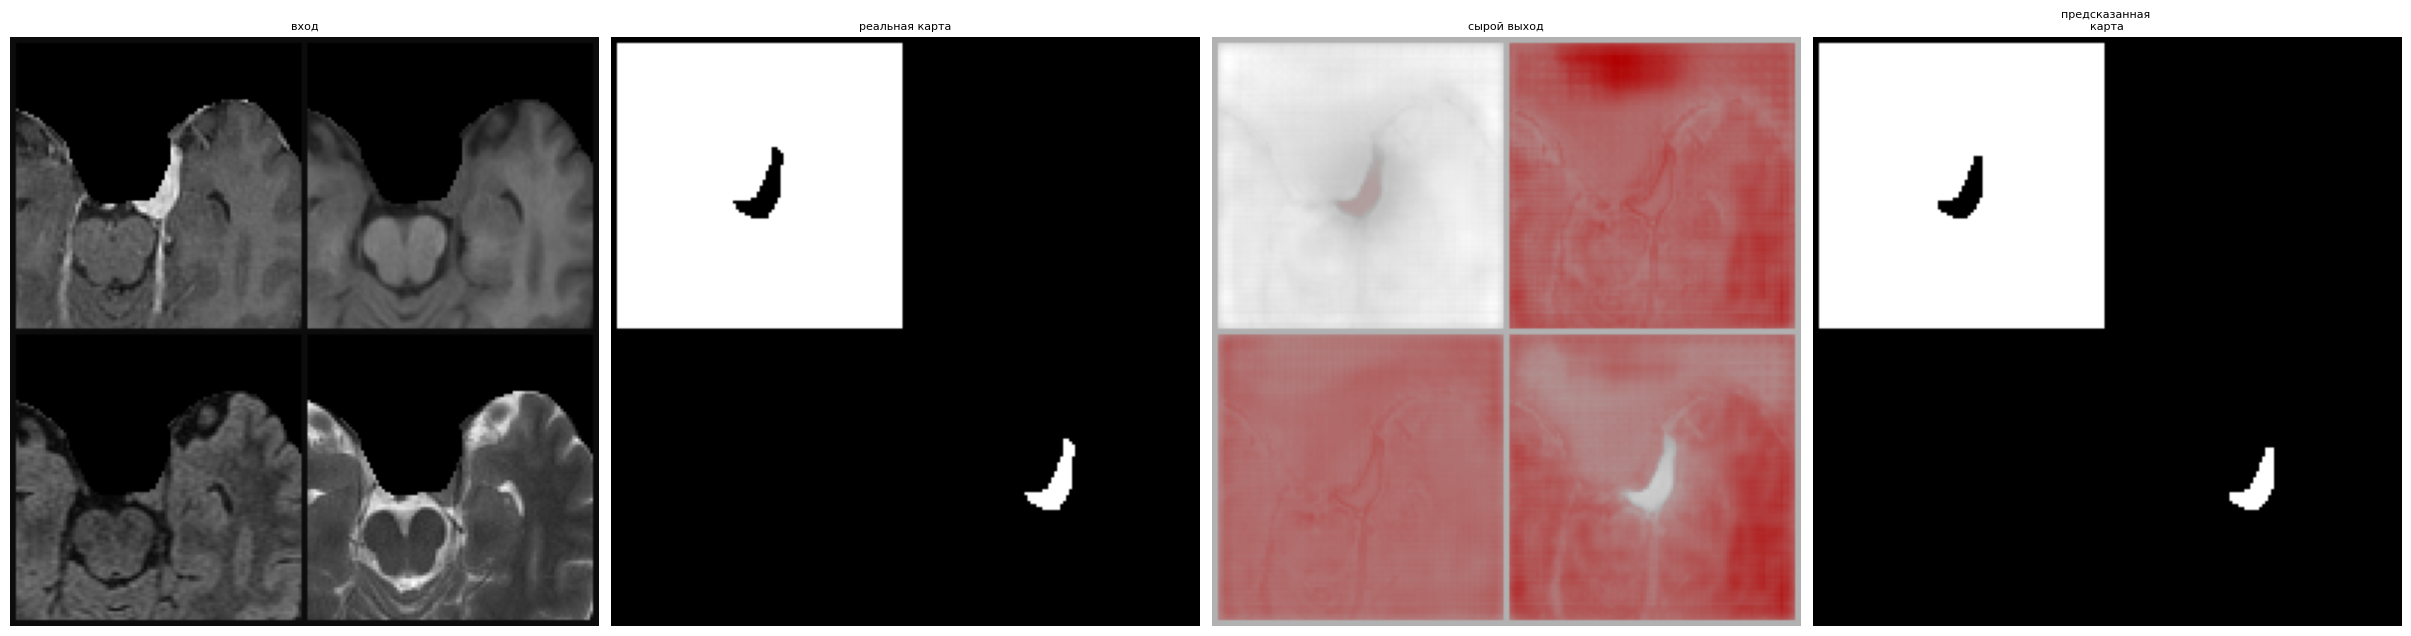

In [12]:
plot_preds(learner, dstest[18], softmax=True)
plot_preds(learner, dstest[19], softmax=True)
plot_preds(learner, dstest[20], softmax=True)

In [72]:
eval_on_rhuh_slices(learner, r"E:\dataset\RHUH-GBM\RHUH-GBM_nii_v1\RHUH-0039\1")

interactive(children=(Checkbox(value=False, description='color'), IntSlider(value=77, description='s0', max=15…

In [62]:
show_slices(nifti.read(find_file_containing(r"E:\dataset\RHUH-GBM\RHUH-GBM_nii_v1\RHUH-0019\1", "t1ce.")))

interactive(children=(Checkbox(value=False, description='color'), IntSlider(value=77, description='s0', max=15…

<function glio.jupyter_tools.show_slices.<locals>.f(color, **kwargs)>

In [ ]:
from monai.networks.nets import HighResNet # type:ignore

summary(HighResNet(2, 4, 4), (8, 4, 96,96))

In [ ]:
MODEL = HighResNet(2, 4,4)
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-2
BATCH_SIZE = 48
N_EPOCHS = 100

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = AdamWScheduleFree(MODEL.parameters(), lr=LR, eps=1e-6)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()
#model = gnn.LSUV(model, dl_train)

LEARNER_NAME = f"{NAME} lr={LR} bs={BATCH_SIZE} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16),
                         Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), Summary(), Accelerate("no"), 
                         Metric_PredsTargetsFn(DiceLoss(softmax=True), step=4),
                         FastProgressBar(plot=True, step_batch=16, metrics=
                                         ["train loss", "test loss", "train fn - monai.losses.dice.DiceLoss", "test fn - monai.losses.dice.DiceLoss"]),
                         ),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest)

plt.show()
plot_preds(learner, dstrain[3], softmax=True)
plot_preds(learner, dstrain[4], softmax=True)
plot_preds(learner, dstrain[6], softmax=True)


In [ ]:
from monai.networks.nets import SegResNetDS # type:ignore

summary(SegResNetDS(2, in_channels=4, out_channels=4, init_filters=16), (8, 4, 96,96))

In [ ]:
MODEL = SegResNetDS(2, in_channels=4, out_channels=4, init_filters=24)
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-2
BATCH_SIZE = 64
N_EPOCHS = 100

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = AdamWScheduleFree(MODEL.parameters(), lr=LR, eps=1e-6)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()
#model = gnn.LSUV(model, dl_train)

LEARNER_NAME = f"{NAME} lr={LR} bs={BATCH_SIZE} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16),
                         Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), Summary(), Accelerate("no"), 
                         Metric_PredsTargetsFn(DiceLoss(softmax=True), step=4),
                         FastProgressBar(plot=True, step_batch=16, metrics=
                                         ["train loss", "test loss", "train fn - monai.losses.dice.DiceLoss", "test fn - monai.losses.dice.DiceLoss"]),
                         ),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest)

plt.show()
plot_preds(learner, dstrain[3], softmax=True)
plot_preds(learner, dstrain[4], softmax=True)
plot_preds(learner, dstrain[6], softmax=True)
